# NIRCam imager simulator

In [1]:
import os
# For examining outputs
from glob import glob
from scipy.stats import sigmaclip
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [2]:
os.environ["MIRAGE_DATA"] = "/Users/spacegrey/opt/anaconda3/envs/mirage/lib/python3.7/site-packages/mirage/reference_files/mirage_data/"
os.environ["CRDS_DATA"] = "/Users/spacegrey/crds_cache"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"

In [3]:
# mirage imports
import yaml
from mirage import imaging_simulator
from mirage.seed_image import catalog_seed_image
from mirage.dark import dark_prep
from mirage.ramp_generator import obs_generator
from mirage.yaml import yaml_generator

from mirage.catalogs.catalog_generator import ExtendedCatalog
from mirage.catalogs.create_catalog import combine_catalogs
from mirage.imaging_simulator import ImgSim
from mirage.reference_files.downloader import download_file
#from mirage.seed_image.fits_seed_image import ImgSeed

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


## Calculate the conversion factor from Jy to ADU/s
Included:
- Telescope aperture (D)
- Filter width (dlam)
- Sensor gain in e-/ADU (gain)
- Quantum efficiency (QE)

Not included:
- Filter transmissivity
- Atmospheric extinction

In [279]:
from astropy import units as u
from astropy import constants as const
D = 6.5 * u.m
QE = 0.9
gain = 2.05
lam_ref = 2 * u.um
dlam = 0.457 * u.um
E_ph = const.h * const.c / lam_ref.to(u.m)
Jy2SI = (1 * u.Jy).to(u.J * u.s**-1 * u.m**-2 * u.um**-1, equivalencies=u.spectral_density(2* u.um))
Jy2DN = (Jy2SI / E_ph) * (D/2)**2 * dlam * QE * (1 / gain)
print("1 Jy at {0:5.2f} corresponds to {1:5.2f}".format(lam_ref, Jy2DN))

1 Jy at  2.00 um corresponds to 15991365.34 1 / s


## Simulation configs

In [34]:
# Specify the xmnl and pointing files exported from APT
xml_file = './image2_data/image2_shallow4.xml'
pointing_file = './image2_data/image2_shallow4.pointing'

# Source catalogs to be used.
cat_dict = {'extended':'image2_data/source_catalog_file.cat'}

# Set reference file values. 
# Setting to 'crds_full_name' will search for and download needed calibration reference files (commonly referred to as CRDS reference files) when the yaml_generator is run. 
# Setting to 'crds' will put placeholders in the yaml files and save the downloading for when the simulated images are created.
reffile_defaults = 'crds'

# Optionally set the cosmic ray library and rate
cosmic_rays = {'library': 'SUNMAX', 'scale': 1.0}

# Optionally set the background signal rates to be used
background = 'medium'

# Optionally set the telescope roll angle (PAV3) for the observations
pav3 = 0

# Optionally set the observation date to use for the data. Note that this information
# is placed in the headers of the output files, but not used by Mirage in any way.
dates = '2022-10-31'

ghosts = False
convolve_ghosts = False

# Set the directory into which the yaml files and simulation output will be written
yaml_dir = './image2_data/'
simulation_dir = './image2_sim/'

# specify the data reduction state of the Mirage outputs
datatype = 'linear'

## Generate yaml input file

In [35]:
# For simu for the 1st time, run the yaml generator 
yam = yaml_generator.SimInput(input_xml=xml_file, pointing_file=pointing_file,
                              catalogs=cat_dict, cosmic_rays=cosmic_rays,
                              background=background, roll_angle=pav3,
                              dates=dates, reffile_defaults=reffile_defaults,
                              add_ghosts=ghosts, convolve_ghosts_with_psf=convolve_ghosts,
                              verbose=True, output_dir=yaml_dir,
                              simdata_output_dir=simulation_dir,
                              datatype=datatype)
yam.create_inputs()

yfiles = glob(os.path.join(yaml_dir,'jw*.yaml'))

2021-05-31 18:04:33,156 - mirage.yaml.yaml_generator - INFO - Running yaml_generator....

2021-05-31 18:04:33,156 - stpipe - INFO - Running yaml_generator....

2021-05-31 18:04:33,156 - stpipe - INFO - Running yaml_generator....

2021-05-31 18:04:33,163 - mirage.yaml.yaml_generator - INFO - using APT xml file: ./image2_data/image2_shallow4.xml

2021-05-31 18:04:33,163 - stpipe - INFO - using APT xml file: ./image2_data/image2_shallow4.xml

2021-05-31 18:04:33,163 - stpipe - INFO - using APT xml file: ./image2_data/image2_shallow4.xml

2021-05-31 18:04:33,167 - mirage.yaml.yaml_generator - INFO - Original log file name: ./mirage_latest.log
2021-05-31 18:04:33,167 - stpipe - INFO - Original log file name: ./mirage_latest.log
2021-05-31 18:04:33,167 - stpipe - INFO - Original log file name: ./mirage_latest.log
2021-05-31 18:04:33,208 - mirage.apt.read_apt_xml - INFO - Running read_apt_xml....

2021-05-31 18:04:33,208 - stpipe - INFO - Running read_apt_xml....

2021-05-31 18:04:33,208 - st

## Run the simulation

In [36]:
# Run all steps of the imaging simulator for yaml file #1
yfile = './image2_data/jw00005001001_01101_00001_nrca1.yaml'

img_sim = imaging_simulator.ImgSim()
img_sim.paramfile = yfile
img_sim.create()

2021-05-31 18:04:38,711 - mirage.imaging_simulator - INFO - 

Running imaging_simulator....

2021-05-31 18:04:38,711 - stpipe - INFO - 

Running imaging_simulator....

2021-05-31 18:04:38,711 - stpipe - INFO - 

Running imaging_simulator....

2021-05-31 18:04:38,717 - mirage.imaging_simulator - INFO - using parameter file: ./image2_data/jw00005001001_01101_00001_nrca1.yaml
2021-05-31 18:04:38,717 - stpipe - INFO - using parameter file: ./image2_data/jw00005001001_01101_00001_nrca1.yaml
2021-05-31 18:04:38,717 - stpipe - INFO - using parameter file: ./image2_data/jw00005001001_01101_00001_nrca1.yaml
2021-05-31 18:04:38,755 - mirage.seed_image.catalog_seed_image - INFO - 

Running catalog_seed_image..

2021-05-31 18:04:38,755 - stpipe - INFO - 

Running catalog_seed_image..

2021-05-31 18:04:38,755 - stpipe - INFO - 

Running catalog_seed_image..

2021-05-31 18:04:38,759 - mirage.seed_image.catalog_seed_image - INFO - Reading parameter file: ./image2_data/jw00005001001_01101_00001_nrca1.

## Plot results

0.0 4105.265682907198


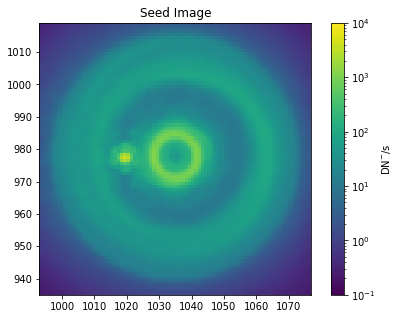

In [37]:
# Plot seed image
plt.figure(figsize=(7,5))
extent = (xmin, xmax, ymin, ymax) = (993, 1077, 935, 1019)
#extent = (xmin, xmax, ymin, ymax) = (993-50, 1077+50, 935-50, 1019+50)
plt.imshow(img_sim.seedimage[ymin:ymax,xmin:xmax], extent=extent,norm=LogNorm(vmin=1e-1,vmax=1e4), origin="lower")
plt.title('Seed Image')
plt.colorbar().set_label('DN$^{-}$/s')
print(img_sim.seedimage.min(), img_sim.seedimage.max())


(1, 10, 2048, 2048)


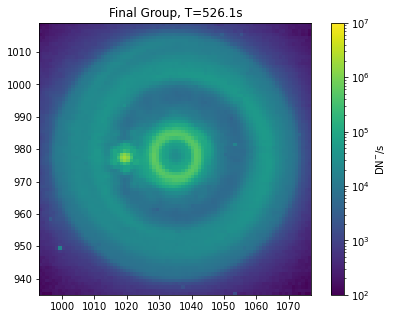

In [38]:
# Plot final image
lin_file = 'image2_sim/jw00005001001_01101_00001_nrca1_linear.fits'
with fits.open(lin_file) as hdulist:
    linear_data = hdulist['SCI'].data
print(linear_data.shape)
plt.figure(figsize=(7,5))
extent = (xmin, xmax, ymin, ymax) = (993, 1077, 935, 1019)
#extent = (xmin, xmax, ymin, ymax) = (993-50, 1077+50, 935-50, 1019+50)

cmap = plt.cm.viridis
cmap.set_bad(color=cmap(0))
plt.imshow(linear_data[0, 9, ymin:ymax, xmin:xmax], extent=extent,norm=LogNorm(vmin=1e2,vmax=1e7), origin="lower")
plt.title('Final Group, T=526.1s')
plt.colorbar().set_label('DN$^{-}$/s')
#print(linear_data[0,3,:,:].min(), linear_data[0,3,:,:].max())


# Tests and Debugs

In [29]:
# test make seed image
from mirage.seed_image import catalog_seed_image
yfile = './image2_data/jw00005001001_01101_00001_nrca1.yaml'
cat = catalog_seed_image.Catalog_seed()
cat.paramfile = yfile
cat.make_seed()

2021-05-31 17:59:50,952 - mirage.seed_image.catalog_seed_image - INFO - 

Running catalog_seed_image..

2021-05-31 17:59:50,952 - stpipe - INFO - 

Running catalog_seed_image..

2021-05-31 17:59:50,952 - stpipe - INFO - 

Running catalog_seed_image..

2021-05-31 17:59:50,954 - mirage.seed_image.catalog_seed_image - INFO - Reading parameter file: ./image2_data/jw00005001001_01101_00001_nrca1.yaml

2021-05-31 17:59:50,954 - stpipe - INFO - Reading parameter file: ./image2_data/jw00005001001_01101_00001_nrca1.yaml

2021-05-31 17:59:50,954 - stpipe - INFO - Reading parameter file: ./image2_data/jw00005001001_01101_00001_nrca1.yaml

2021-05-31 17:59:50,957 - mirage.seed_image.catalog_seed_image - INFO - Original log file name: ./mirage_latest.log
2021-05-31 17:59:50,957 - stpipe - INFO - Original log file name: ./mirage_latest.log
2021-05-31 17:59:50,957 - stpipe - INFO - Original log file name: ./mirage_latest.log
2021-05-31 17:59:50,965 - mirage.utils.utils.full_paths - INFO - From CRDS, 

In [31]:
# test make seed position
filename = cat.params['simSignals']['extended']
extendedscale = 2
lines, pixelflag, magsys = cat.read_point_source_file(filename)
indexes = lines['index']
indexes, lines = cat.remove_outside_fov_sources(indexes, lines, pixelflag, 4096)
mag_column = cat.select_magnitude_column(lines, filename)
for indexnum, values in zip(indexes, lines):
    pixelx, pixely, ra, dec, ra_str, dec_str = cat.get_positions(values['x_or_RA'],
                                                                values['y_or_Dec'],
                                                                pixelflag, 4096)
    mag = None
    ext_stamp = fits.getdata(values['filename'])
    eshape = np.array(ext_stamp.shape)
    edgey, edgex = eshape // 2
    miny = 0
    maxy = cat.subarray_bounds[3] - cat.subarray_bounds[1]
    minx = 0
    maxx = cat.subarray_bounds[2] - cat.subarray_bounds[0]
    miny -= edgey
    maxy += edgey
    minx -= edgex
    maxx += edgex
    norm_factor = np.sum(ext_stamp)
    countrate = norm_factor * extendedscale
    if pixely > miny and pixely < maxy and pixelx > minx and pixelx < maxx:
        entry = [indexnum, pixelx, pixely, ra_str, dec_str, ra, dec, mag]

2021-05-31 18:00:09,019 - mirage.seed_image.catalog_seed_image - WARNING - WARNING: Catalog source_catalog_file.cat does not have a magnitude column called nircam_f200w_magnitude, but does have a generic 'magnitude' column. Continuing simulation using that.
2021-05-31 18:00:09,019 - stpipe - WARNING - WARNING: Catalog source_catalog_file.cat does not have a magnitude column called nircam_f200w_magnitude, but does have a generic 'magnitude' column. Continuing simulation using that.
2021-05-31 18:00:09,019 - stpipe - WARNING - WARNING: Catalog source_catalog_file.cat does not have a magnitude column called nircam_f200w_magnitude, but does have a generic 'magnitude' column. Continuing simulation using that.


In [32]:
pixelx, pixely, ra, dec, ra_str, dec_str, minx, maxx, miny, maxy

(1035.2140797253817,
 977.9647843760524,
 47.554,
 -10.1,
 '03:10:12.9600',
 '-10:05:60.0000',
 -420,
 2467,
 -420,
 2467)

In [102]:
cat.coord_transform

<CompoundModel(offset_0=1., offset_1=1., offset_2=-1024.5, offset_3=-1024.5, c0_0_5=-0., c1_0_5=0.03113927, c2_0_5=0., c3_0_5=0., c4_0_5=-0., c5_0_5=0., c0_1_5=0., c0_2_5=-0.00000003, c0_3_5=0., c0_4_5=-0., c0_5_5=-0., c1_1_5=-0.00000021, c1_2_5=0., c1_3_5=-0., c1_4_5=0., c2_1_5=0., c2_2_5=-0., c2_3_5=0., c3_1_5=-0., c3_2_5=0., c4_1_5=0., c0_0_6=0., c1_0_6=0.00002575, c2_0_6=0.00000007, c3_0_6=0., c4_0_6=-0., c5_0_6=0., c0_1_6=0.03132232, c0_2_6=-0.00000014, c0_3_6=0., c0_4_6=-0., c0_5_6=0., c1_1_6=0.00000004, c1_2_6=0., c1_3_6=-0., c1_4_6=0., c2_1_6=0., c2_2_6=-0., c2_3_6=0., c3_1_6=-0., c3_2_6=0., c4_1_6=0., c0_0_8=0., c1_0_8=-0.99995176, c0_1_8=-0.00982238, c0_0_9=0., c1_0_9=-0.00982238, c0_1_9=0.99995176, offset_10=120.525464, offset_11=-527.543132)>

In [118]:
import pysiaf
loc_v2, loc_v3 = pysiaf.utils.rotations.getv2v3(cat.attitude_matrix, 47.55, -10.1)
pixelx, pixely = cat.coord_transform.inverse(loc_v2, loc_v3)
pixelx, pixely


(1490.2794964091681, 981.6426584758801)